In [1]:
import data_prep as dp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## Preprocessing danych

Pliki matches.csv oraz standings.cvs zostały wstępnie przygotowane przy pomocy csv_prep.py 

In [115]:
matches = pd.read_csv("Datasets/matches.csv")
standings = pd.read_csv("Datasets/standings.csv")

matches['Date'] = pd.to_datetime(matches['Date'], dayfirst=True) 
processed_matches = pd.DataFrame(columns=['Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'HomeGoals', 'AwayGoals',
                                 'HTR', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'StandingDiff', 'HomeWins', 'AwayWins',
                                 'HomeDraws', 'AwayDraws', 'HomeHalfTimeWins', 'AwayHalfTimeWins', 'HomeHalfTimeDraws',
                                 'AwayHalfTimeDraws', 'HomeAvgGoals', 'AwayAvgGoals', 'HomeAvgHalftimeGoals', 'AwayAvgHalftimeGoals',
                                 'HomeAvgShots', 'AwayAvgShots', 'HomeAvgShotsOnTarget', 'AwayAvgShotsOnTarget'
                                ])

processed_matches = matches.apply(lambda row: dp.get_match_stats(row, matches, standings, amount=5), axis=1)
processed_matches = pd.DataFrame(processed_matches.tolist())
processed_matches.to_csv("Datasets/processed_matches.csv", index=False)

## Analiza danych

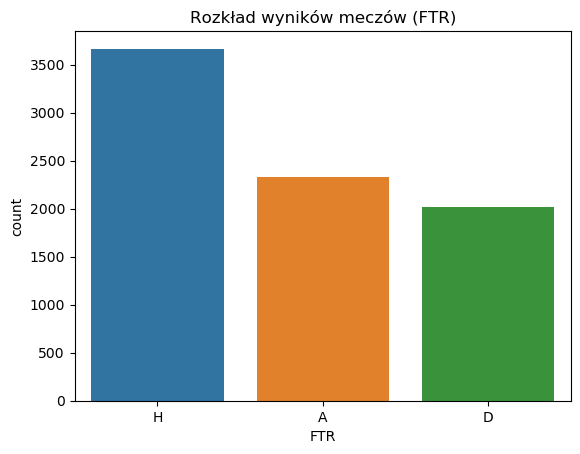

In [4]:
sns.countplot(x='FTR', data=processed_matches)
plt.title('Rozkład wyników meczów (FTR)')
plt.show()

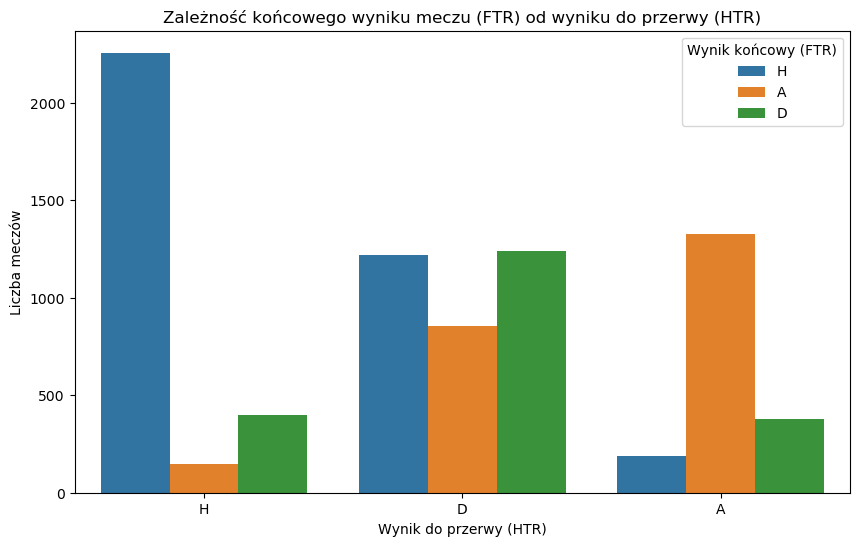

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='HTR', hue='FTR', data=processed_matches)
plt.title('Zależność końcowego wyniku meczu (FTR) od wyniku do przerwy (HTR)')
plt.xlabel('Wynik do przerwy (HTR)')
plt.ylabel('Liczba meczów')
plt.legend(title='Wynik końcowy (FTR)')
plt.show()

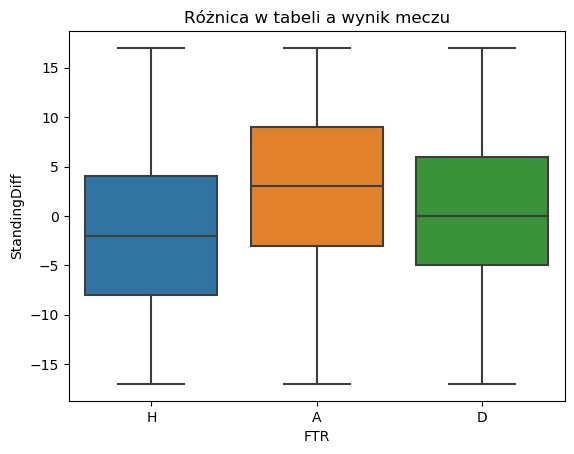

In [118]:
sns.boxplot(x='FTR', y='StandingDiff', data=processed_matches)
plt.title('Różnica w tabeli a wynik meczu')
plt.show()

Przeanalizujmy ważność poszczególnych cech

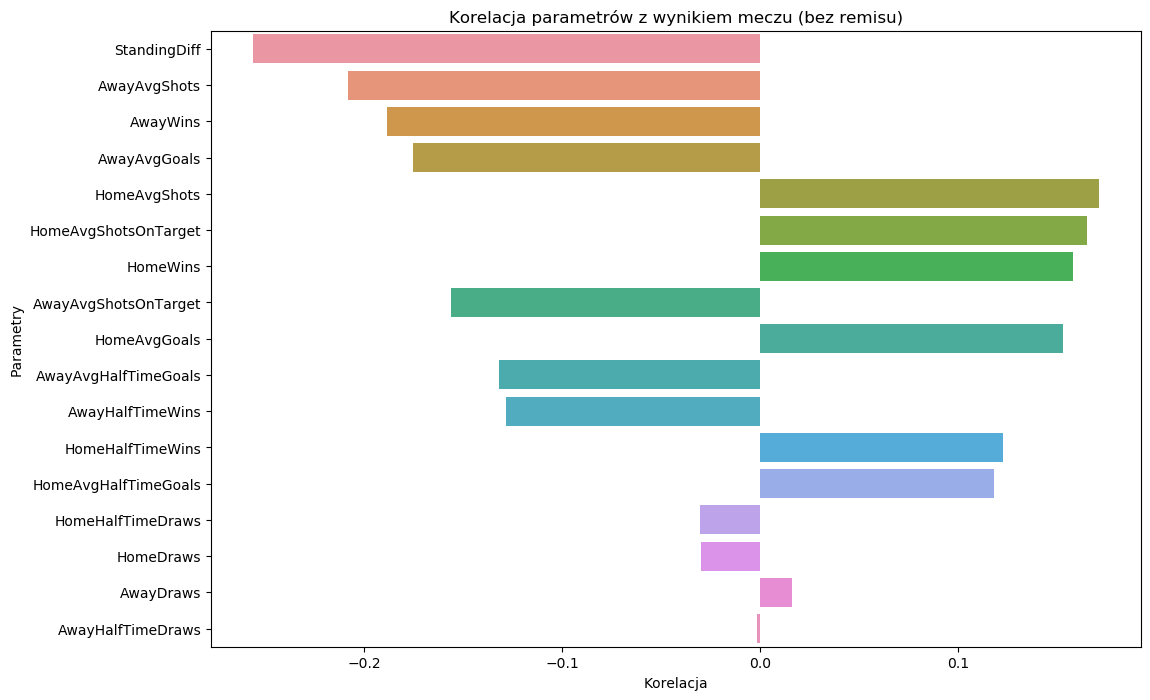

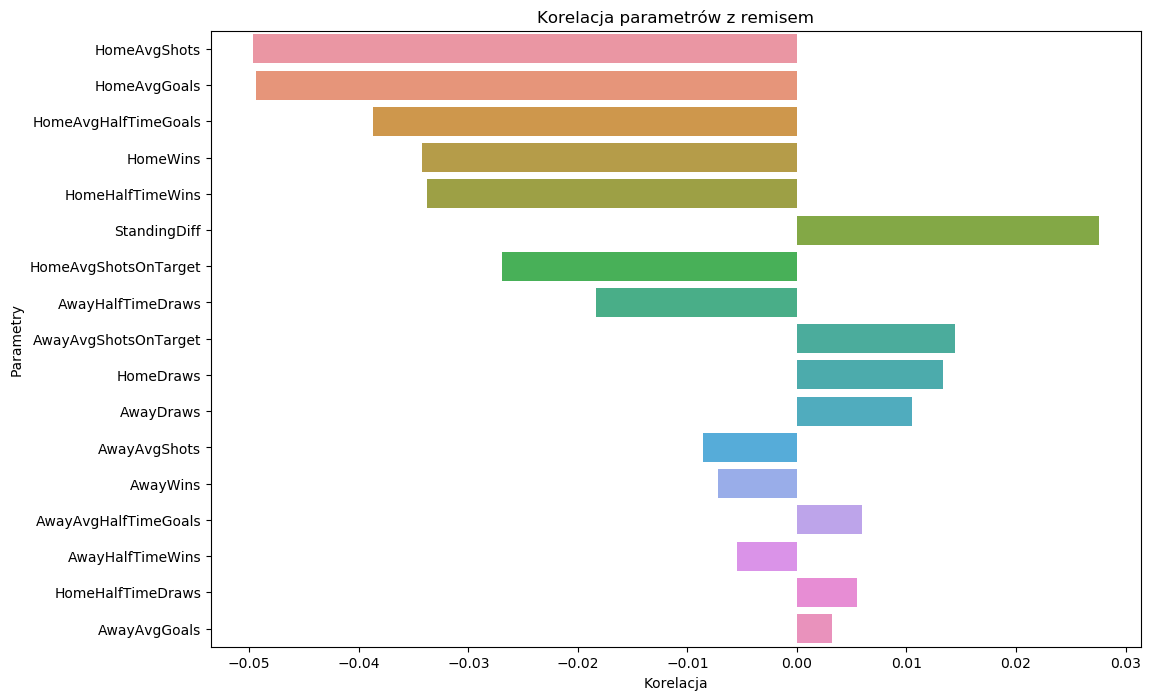

In [2]:
processed_matches = pd.read_csv("Datasets/processed_matches.csv")

ftr_mapping = {'H': 1, 'D': 0, 'A': -1}
processed_matches['FTR'] = processed_matches['FTR'].map(ftr_mapping)

X = processed_matches.drop(columns=['Season', 'Date', 'HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals'])
y = processed_matches['FTR']

correlation_matrix = X.corr()
ftr_correlation = correlation_matrix['FTR'].drop('FTR')
ftr_correlation = ftr_correlation.reindex(ftr_correlation.abs().sort_values(ascending=False).index)

plt.figure(figsize=(12, 8))
sns.barplot(x=ftr_correlation.values, y=ftr_correlation.index)
plt.title('Korelacja parametrów z wynikiem meczu (bez remisu)')
plt.xlabel('Korelacja')
plt.ylabel('Parametry')
plt.show()

processed_matches['IsDraw'] = (processed_matches['FTR'] == 0).astype(int)

X = processed_matches.drop(columns=['Season', 'Date', 'HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'FTR'])
y = processed_matches['IsDraw']

correlation_matrix = X.corr()
draw_correlation = correlation_matrix['IsDraw'].drop('IsDraw')
draw_correlation = draw_correlation.reindex(draw_correlation.abs().sort_values(ascending=False).index)

plt.figure(figsize=(12, 8))
sns.barplot(x=draw_correlation.values, y=draw_correlation.index)
plt.title('Korelacja parametrów z remisem')
plt.xlabel('Korelacja')
plt.ylabel('Parametry')
plt.show()

## Dobór klasyfikatorów

In [3]:
processed_matches = pd.read_csv("Datasets/processed_matches.csv")

ftr_mapping = {'H': 1, 'D': 0, 'A': -1}
processed_matches['FTR'] = processed_matches['FTR'].map(ftr_mapping)

test_seasons = [2021, 2022]
test_data = processed_matches[processed_matches['Season'].isin(test_seasons)]
train_val_data = processed_matches[~processed_matches['Season'].isin(test_seasons)]

X_train_val = train_val_data.drop(columns=['Season', 'Date', 'HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'FTR', 'HTR'])
y_train_val = train_val_data['FTR']
X_test = test_data.drop(columns=['Season', 'Date', 'HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'FTR', 'HTR'])
y_test = test_data['FTR']

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

models = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'RandomForest': RandomForestClassifier(),
    'K-NearestNeighbors': KNeighborsClassifier(),
    'SupportVectorClassifier': SVC(probability=True),
    'GaussianNaiveBayes': GaussianNB(),
    'GradientBoosting': GradientBoostingClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Multi-LayerPerceptron': MLPClassifier(max_iter=1000),
    'StochasticGradientDescent': SGDClassifier(max_iter=1000, tol=1e-3)
}

In [27]:

results = {}

for name, model in models.items():
    print(name)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    f1 = f1_score(y_val, predictions, average='macro')
    print('accuracy: ', f'{accuracy}')
    print('f1_score: ', f'{f1}')
    results[name] = accuracy

sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)[:5]

for name, _ in sorted_results:
    joblib.dump(models[name], f'Classifiers/{name}.joblib')

LogisticRegression
accuracy:  0.5241046831955923
f1_score:  0.3721186754169663
RandomForest
accuracy:  0.5151515151515151
f1_score:  0.4168562986222158
K-NearestNeighbors
accuracy:  0.45041322314049587
f1_score:  0.4116704866208225
SupportVectorClassifier
accuracy:  0.5268595041322314
f1_score:  0.35572613064148967
GaussianNaiveBayes
accuracy:  0.4855371900826446
f1_score:  0.40407982511032375
GradientBoosting
accuracy:  0.509641873278237
f1_score:  0.3710722723041941
DecisionTree
accuracy:  0.40289256198347106
f1_score:  0.372955943554176
AdaBoost
accuracy:  0.5130853994490359
f1_score:  0.37539442861877764
Multi-LayerPerceptron
accuracy:  0.5
f1_score:  0.39448864623411034
StochasticGradientDescent
accuracy:  0.25068870523415976
f1_score:  0.18970257976381433


In [51]:
best_models = [joblib.load(f'Classifiers/{name}.joblib') for name, _ in sorted_results[:5]]
eclf = EnsembleVoteClassifier(clfs=best_models, voting='soft')

eclf.fit(X_train, y_train)
joblib.dump(eclf, 'Classifiers/EnsembleClassifier.joblib')

['Classifiers/EnsembleClassifier.joblib']

## Analiza modelu

accuracy_score: 0.5236842105263158
f1_score: 0.3915220137285897


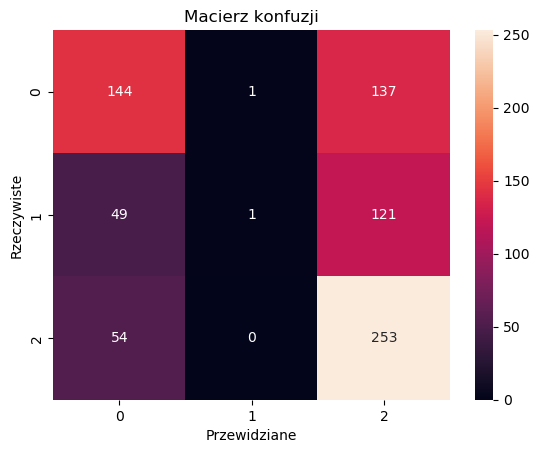

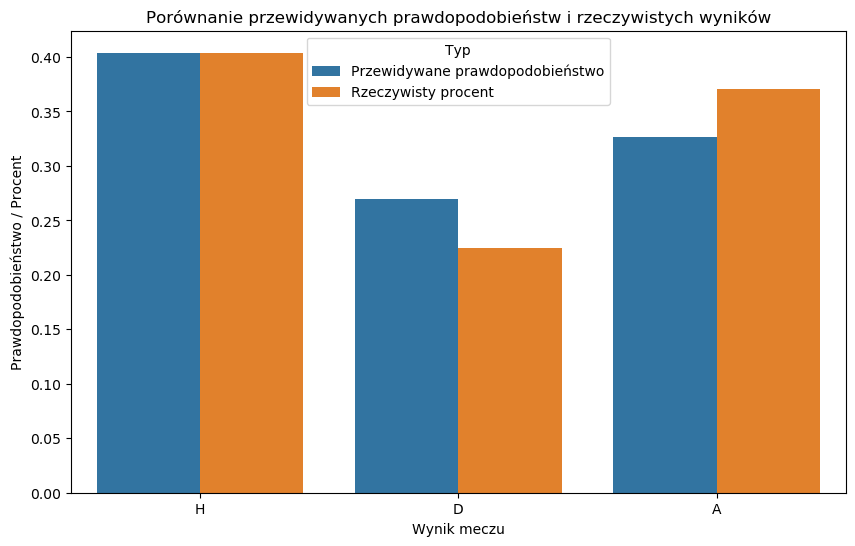

In [4]:
model = joblib.load('Classifiers/EnsembleClassifier.joblib')

y_pred = model.predict(X_test)

print('accuracy_score:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred, average='macro'))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Macierz konfuzji')
plt.xlabel('Przewidziane')
plt.ylabel('Rzeczywiste')
plt.show()

y_proba = model.predict_proba(X_test)
avg_proba = y_proba.mean(axis=0)

unique, counts = np.unique(y_test, return_counts=True)
actual_proba = counts / len(y_test)

ftr_mapping_rev = {1: 'H', 0: 'D', -1: 'A'}
actual_proba_dict = {ftr_mapping_rev[k]: v for k, v in zip(unique, actual_proba)}
avg_proba_dict = {'H': avg_proba[2], 'D': avg_proba[1], 'A': avg_proba[0]}

labels = ['H', 'D', 'A']
predicted_proba = [avg_proba_dict[l] for l in labels]
actual_proba = [actual_proba_dict.get(l, 0) for l in labels]

data = pd.DataFrame({
    'Wynik meczu': labels * 2,
    'Wartość': predicted_proba + actual_proba,
    'Typ': ['Przewidywane prawdopodobieństwo'] * 3 + ['Rzeczywisty procent'] * 3
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Wynik meczu', y='Wartość', hue='Typ', data=data)
plt.xlabel('Wynik meczu')
plt.ylabel('Prawdopodobieństwo / Procent')
plt.title('Porównanie przewidywanych prawdopodobieństw i rzeczywistych wyników')
plt.legend(title='Typ')
plt.show()

## Przykład użycia 

In [6]:
import predictor as pr

model = joblib.load('Classifiers/EnsembleClassifier.joblib')
example_matches = pd.read_csv('Datasets/example_matches.csv')
pr.display_prediction(model, example_matches)

2022-05-15 Leeds Brighton
Przewidywany wynik:  H
Rozkład prawdopodobieństwa:  H: 0.3697203353273858 D: 0.28243343772836627 A: 0.34784622694424794


2022-05-15 Watford Leicester
Przewidywany wynik:  A
Rozkład prawdopodobieństwa:  H: 0.3375819503789961 D: 0.27199470138927423 A: 0.3904233482317297


2022-05-15 West Ham Man City
Przewidywany wynik:  A
Rozkład prawdopodobieństwa:  H: 0.19212576572668308 D: 0.22412684995471768 A: 0.5837473843185993


2022-05-15 Wolves Norwich
Przewidywany wynik:  H
Rozkład prawdopodobieństwa:  H: 0.47161357546542104 D: 0.2857078396125664 A: 0.2426785849220125


2022-05-15 Everton Brentford
Przewidywany wynik:  A
Rozkład prawdopodobieństwa:  H: 0.36757600479500807 D: 0.2524869157928176 A: 0.3799370794121743


2022-05-16 Newcastle Arsenal
Przewidywany wynik:  A
Rozkład prawdopodobieństwa:  H: 0.31976216665324586 D: 0.2727064014184916 A: 0.4075314319282626


2022-05-17 Southampton Liverpool
Przewidywany wynik:  A
Rozkład prawdopodobieństwa:  H: 0.1681032